In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset/IMDB Dataset.csv


In [ ]:
!pip -q install nltk gensim scikit-learn tensorflow umap-learn

import os, re, string, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt


In [12]:
DATA_PATH = "/kaggle/input/imdb-dataset/IMDB Dataset.csv"

df = pd.read_csv(DATA_PATH)

df = df.rename(columns={
    "review": "text",
    "sentiment": "label"
})

df = df.dropna(subset=["text", "label"]).copy()
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(str)

print(df.shape)
df.head()


(50000, 2)


,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [13]:
STOPWORDS = set(stopwords.words("english"))

def clean_text(t: str) -> str:
    t = t.lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)               # remove URLs
    t = re.sub(r"\S+@\S+", " ", t)                       # remove emails
    t = re.sub(r"[%s]" % re.escape(string.punctuation), " ", t)
    t = re.sub(r"\d+", " ", t)                           # remove numbers
    t = re.sub(r"\s+", " ", t).strip()
    # remove stopwords
    tokens = [w for w in t.split() if w not in STOPWORDS and len(w) > 2]
    return " ".join(tokens)

df["text_clean"] = df["text"].apply(clean_text)

# Train/val/test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print("Train/Val/Test:", train_df.shape, val_df.shape, test_df.shape)


Train/Val/Test: (32000, 3) (8000, 3) (10000, 3)


In [ ]:
X_train = train_df["text_clean"].values
y_train = train_df["label"].values
X_val   = val_df["text_clean"].values
y_val   = val_df["label"].values
X_test  = test_df["text_clean"].values
y_test  = test_df["label"].values

# BoW
bow = CountVectorizer(max_features=20000, ngram_range=(1,2))
Xtr_bow = bow.fit_transform(X_train)
Xva_bow = bow.transform(X_val)
Xte_bow = bow.transform(X_test)

# TF-IDF
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
Xtr_tfidf = tfidf.fit_transform(X_train)
Xva_tfidf = tfidf.transform(X_val)
Xte_tfidf = tfidf.transform(X_test)

Xtr_bow.shape, Xtr_tfidf.shape


((32000, 20000), (32000, 50000))

In [ ]:
def eval_model(name, model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    f1 = f1_score(yte, pred, average="weighted")
    print(f"\n{name} | acc={acc:.4f} f1={f1:.4f}")
    print(classification_report(yte, pred))
    return {"model": name, "acc": acc, "f1_weighted": f1}

results = []

# Logistic Regression
results.append(eval_model("LogReg (BoW)", LogisticRegression(max_iter=3000), Xtr_bow, Xte_bow, y_train, y_test))
results.append(eval_model("LogReg (TFIDF)", LogisticRegression(max_iter=3000), Xtr_tfidf, Xte_tfidf, y_train, y_test))

# Linear SVM
results.append(eval_model("LinearSVC (BoW)", LinearSVC(), Xtr_bow, Xte_bow, y_train, y_test))
results.append(eval_model("LinearSVC (TFIDF)", LinearSVC(), Xtr_tfidf, Xte_tfidf, y_train, y_test))

pd.DataFrame(results).sort_values("f1_weighted", ascending=False)



LogReg (BoW) | acc=0.8862 f1=0.8862
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      5000
    positive       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


LogReg (TFIDF) | acc=0.9006 f1=0.9006
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


LinearSVC (BoW) | acc=0.8657 f1=0.8657
              precision    recall  f1-score   support

    negative       0.86      0.87      0.87      5000
    positive       0.87      0.86      0.87      5000

    accuracy                           0.87     10000
   macro avg

,model,acc,f1_weighted
3,LinearSVC (TFIDF),0.9053,0.905297
1,LogReg (TFIDF),0.9006,0.900590
0,LogReg (BoW),0.8862,0.886200
2,LinearSVC (BoW),0.8657,0.865700


In [ ]:
from gensim.models import Word2Vec

sentences = [t.split() for t in df["text_clean"].values]
w2v = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1  # skip-gram
)

print("Vocab size:", len(w2v.wv.index_to_key))
print("Example similar words:", w2v.wv.most_similar(w2v.wv.index_to_key[0], topn=5))


/usr/local/lib/python3.12/dist-packages/google/cloud/aiplatform/models.py:52: FutureWarning: Support for google-cloud-storage < 3.0.0 will be removed in a future version of google-cloud-aiplatform. Please upgrade to google-cloud-storage >= 3.0.0.
  from google.cloud.aiplatform.utils import gcs_utils


Vocab size: 49778
Example similar words: [('film', 0.8925034403800964), ('strangeland', 0.8284709453582764), ('havent', 0.8163511157035828), ('lotta', 0.8144828677177429), ('atleast', 0.811306893825531)]


2026-01-28 18:53:02.874403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769626383.028359      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769626383.073696      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769626383.441439      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769626383.441469      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769626383.441471      55 computation_placer.cc:177] computation placer alr

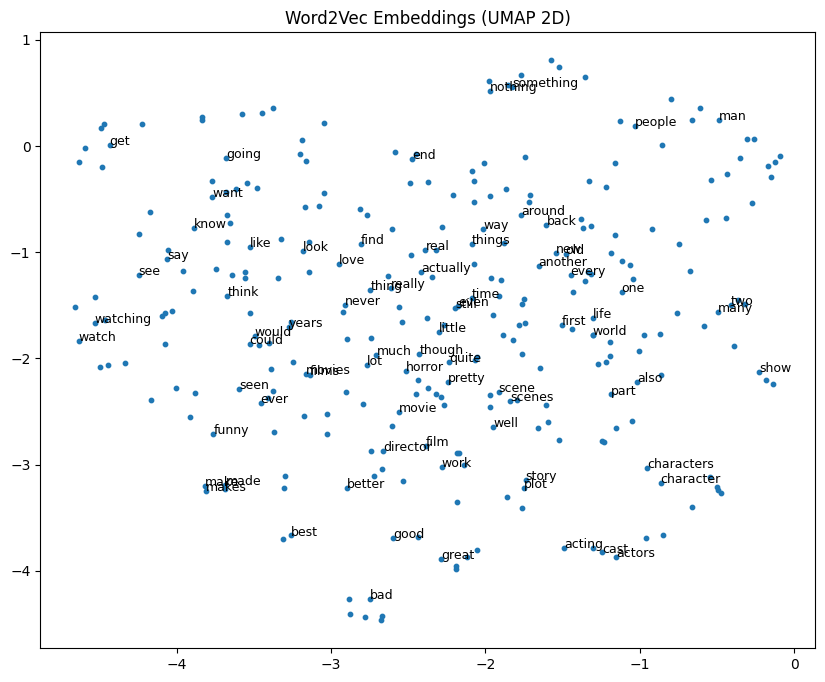

In [ ]:
import umap

# pick top-N frequent words
words = w2v.wv.index_to_key[:300]
vectors = np.array([w2v.wv[w] for w in words])

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
emb2d = reducer.fit_transform(vectors)

plt.figure(figsize=(10, 8))
plt.scatter(emb2d[:,0], emb2d[:,1], s=10)
for i, w in enumerate(words[:80]):  # label fewer to keep readable
    plt.text(emb2d[i,0], emb2d[i,1], w, fontsize=9)
plt.title("Word2Vec Embeddings (UMAP 2D)")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

max_words = 50000
max_len = 200

tok = Tokenizer(num_words=max_words, oov_token="<OOV>")
tok.fit_on_texts(train_df["text_clean"].values)

def to_seq(texts):
    return pad_sequences(tok.texts_to_sequences(texts), maxlen=max_len, padding="post", truncating="post")

Xtr_seq = to_seq(train_df["text_clean"].values)
Xva_seq = to_seq(val_df["text_clean"].values)
Xte_seq = to_seq(test_df["text_clean"].values)

# Encode labels
le = LabelEncoder()
ytr_enc = le.fit_transform(y_train)
yva_enc = le.transform(y_val)
yte_enc = le.transform(y_test)

num_classes = len(le.classes_)
num_classes, le.classes_


(2, array(['negative', 'positive'], dtype=object))

In [ ]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Input(shape=(max_len,)),
    layers.Embedding(input_dim=max_words, output_dim=128),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

hist = model.fit(
    Xtr_seq, ytr_enc,
    validation_data=(Xva_seq, yva_enc),
    epochs=8,
    batch_size=64,
    callbacks=[cb],
    verbose=1
)


Epoch 1/8


2026-01-28 18:53:28.193440: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 153ms/step - accuracy: 0.7301 - loss: 0.4970 - val_accuracy: 0.8852 - val_loss: 0.2867
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 154ms/step - accuracy: 0.9386 - loss: 0.1737 - val_accuracy: 0.8817 - val_loss: 0.3165
Epoch 3/8


In [ ]:
probs = model.predict(Xte_seq)
pred_enc = probs.argmax(axis=1)
pred = le.inverse_transform(pred_enc)

acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average="weighted")
print(f"BiLSTM | acc={acc:.4f} f1={f1:.4f}")
print(classification_report(y_test, pred))


In [ ]:
results2 = results + [{"model": "BiLSTM (Embedding)", "acc": acc, "f1_weighted": f1}]
pd.DataFrame(results2).sort_values("f1_weighted", ascending=False)
